#UV treated Silk pattern decomposition
#Instead of using full 9 peaks, this script will instead use "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system
Author links open overlay panelMehtapFevziogluabOguz KaanOzturkbcBruce R.HamakerbcOsvaldo H.Campanellabd" and only analyze 4 "peaks"
 beta-sheet (low frequency)
 random structure & alpha helix
 beta-turn
 Beta sheet (high frequency)

This notebook is bsed on a previously developed tool demonstrating how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition

Modified by Jeff
6.2.22: Need to apply FSD to spectra as I don't think this is being applied here before the least-squares fitting method




In [2]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import scipy

import sys
#maybe need to do this in case I change the path at the end for saving elsewhere?
os.chdir(r'C:\Users\jrosh\Documents\FTIR_Mapping\ftir')
sys.path.append("../")

import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction, gaussian_integral, gaussian_sum
from ftir.modeling.peak_fitting import create_fit_singleplot #added this to avoid additional layer of subplotting of residuals
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file
# import ftir.modeling.peak_definitions 
#from ftir.modeling.peak_definitions import four_peak

import math
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.spatial import ConvexHull

import time
import tkinter as tk
from tkinter import *
from tkinter import filedialog

import seaborn as sns

Setup, Import Code

In [3]:
# import data file in csv format (modify for your file path/file name between the "" if you want to, leave blank for GUI option)
# Takes a csv file with first column being wavenumbers, 2nd and onward are relative intensity values, no heads

# #Manual Filename Entry, commented out and instead using GUI for now
# filenamevar = r"R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\InvenioATR1hr60C0hr3hr6hrUVtestCombinedNoLabel.csv"

filenamevar = r""
#rawData_df ="nil"
if bool(filenamevar):
    rawData_df = pd.read_csv(filenamevar, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)
    
    win.withdraw() # prevents an empty tkinter window from appearing
    #top = Toplevel()
    def func():
        global filenamevar
        filenamevar = filedialog.askopenfilename(multiple = True,filetypes =[ ('DPT,CSV, or typeless OPUS files','*.dpt *.csv .*'),('CSV Files', '*.csv'),('Typeless files from OPUS','.*')],
        parent=win,  title='Open a CSV file of Wavenumber (first column) and data points in subsequent columnns to analyze',
        initialdir='R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\CalibrationOf45cWAing')  #, header=1,)
        global rawData_df
        global wnrawData_df
        #print(filenamevar)
        #print(type(filenamevar))
        print(len(filenamevar))
        if len(filenamevar)>1:
            print("multiple files, tuple")
            spectral_data = {}
            
            for file in filenamevar:
                if filenamevar[0].endswith('.csv'):
                    spectral_data[os.path.basename(file)] = pd.read_csv(file, names = (["wavenumber", os.path.basename(file)])) # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                elif filenamevar[0].endswith('.dpt'):
                    spectral_data[os.path.basename(file)] = pd.read_csv(file,sep = "\t", names = (["wavenumber", os.path.basename(file)])) # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                else:
                    spectral_data[os.path.basename(file)] = pd.read_csv(file,sep = "\t", names = (["wavenumber", os.path.basename(file)])) # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
            rawData_df = pd.DataFrame()
            for key, values in spectral_data.items():
                rawData_df['wavenumber'] = values['wavenumber']
                rawData_df[key] = values[key]
            wnrawData_df = rawData_df #already has wavenumber in the first column header
        elif filenamevar[0].endswith('.dpt'):
            print('single dpt')
            rawData_df = pd.read_csv(filenamevar[0], header=None, sep = "\t") #,names = (["wavenumber",[1,]]))
            #put wavenumber in the first column header
            dims = []
            for i in range(1,rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber'])+ dims
            wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
        elif filenamevar[0].endswith('.csv'):
            print('single csv')
            rawData_df = pd.read_csv(filenamevar[0], header = 1) 
            #put wavenumber in the first column header
            dims = []
            for i in range(1,rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber'])+ dims
            wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
        
        #to do: add something here for single xy file output from OPUS:
        # else:
        #     rawData_df = pd.read_csv(filenamevar, header=None, sep = "\t") #,names = (["wavenumber",[1,]]))
        #     rawData_df
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy() 

    func()
    # quit()

    win.mainloop()

entering GUI file input mode via Tkinter
1
single csv


In [4]:
# # don't forget to change this!!! JEff 8.25
# filenamevar = ('R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/0min.0',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/0min.1',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/0min.2',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/0min.3',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/0min.4',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/5min.0',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/5min.1',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/5min.2',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/5min.3',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/5min.4',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/10min.0',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/10min.1',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/10min.2',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/10min.3',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/10min.4',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/10min.6',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/30min.0',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/30min.1',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/30min.2',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/30min.3',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/30min.4',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/60min.0',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/60min.1',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/60min.2',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/60min.3',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/60min.4',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/120min.0',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/120min.1',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/120min.2',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/120min.3',
#  'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/45Ccurve_xyMinutes/120min.4')

# spectral_data = {}
# for file in filenamevar:
#     spectral_data[os.path.basename(file)] = pd.read_csv(file,sep = "\t", names = (["wavenumber", os.path.basename(file)])) # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
# rawData_df = pd.DataFrame()
# for key, values in spectral_data.items():
#     rawData_df['wavenumber'] = values['wavenumber']
#     rawData_df[key] = values[key]
# wnrawData_df = rawData_df #already has wavenumber in the first column header

In [4]:
# filenamevar[0]
#rawData_df
wnrawData_df

,wavenumber,cols1,cols2,cols3,cols4,cols5,cols6,cols7,cols8,cols9,cols10,cols11,cols12,cols13,cols14,cols15,cols16,cols17,cols18
0,3995.66033,-0.09362,-0.08158,-0.07810,-0.09207,-0.07684,-0.07518,-0.09508,-0.07781,-0.07200,-0.07577,-0.09209,-0.07915,-0.09338,-0.09399,-0.07594,-0.07747,-0.09485,-0.07608
1,3994.23229,-0.09367,-0.08165,-0.07816,-0.09206,-0.07687,-0.07515,-0.09509,-0.07783,-0.07201,-0.07576,-0.09210,-0.07917,-0.09339,-0.09401,-0.07598,-0.07747,-0.09485,-0.07608
2,3992.80425,-0.09366,-0.08169,-0.07815,-0.09202,-0.07684,-0.07508,-0.09506,-0.07782,-0.07196,-0.07571,-0.09205,-0.07914,-0.09336,-0.09397,-0.07594,-0.07742,-0.09480,-0.07605
3,3991.37620,-0.09362,-0.08169,-0.07812,-0.09199,-0.07678,-0.07504,-0.09503,-0.07779,-0.07187,-0.07568,-0.09200,-0.07911,-0.09332,-0.09393,-0.07586,-0.07735,-0.09474,-0.07603
4,3989.94816,-0.09359,-0.08167,-0.07809,-0.09201,-0.07675,-0.07508,-0.09505,-0.07781,-0.07184,-0.07570,-0.09200,-0.07911,-0.09330,-0.09392,-0.07582,-0.07731,-0.09474,-0.07602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,605.48963,0.13839,0.14484,0.14891,0.15892,0.15442,0.15648,0.15466,0.15307,0.16291,0.14932,0.14828,0.14752,0.15661,0.15527,0.15354,0.16148,0.15354,0.16162
2375,604.06159,0.13876,0.14538,0.14964,0.16086,0.15560,0.15916,0.15497,0.15322,0.16464,0.14989,0.14952,0.14794,0.15864,0.15680,0.15585,0.16225,0.15354,0.16273
2376,602.63355,0.13904,0.14606,0.15047,0.16347,0.15695,0.16127,0.15548,0.15358,0.16664,0.15112,0.15046,0.14867,0.16082,0.15854,0.15820,0.16298,0.15392,0.16370
2377,601.20550,0.13899,0.14668,0.15128,0.16635,0.15834,0.16223,0.15601,0.15427,0.16899,0.15278,0.15096,0.14965,0.16295,0.16055,0.16005,0.16373,0.15486,0.16468


In [5]:
# num_in_x=31
# num_in_y = 1

#uncomment below to allow gui to set size of image

# Jeff 6.14.2022 
# Make a simple input for x and y dimensions of mapping
# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# Returns xvalue and yvalue globally
root=tk.Tk()
 
# setting the windows size
root.geometry("450x100")
root.eval('tk::PlaceWindow . center')
#root.lift()

# declaring numerical variables for storing x and y values
x_var=tk.IntVar()
y_var=tk.IntVar()
   
# defining a function that will get x and y values and close the window
def submit():
    global user_message_entry, num_in_x,num_in_y
    # t = Toplevel(root)
    num_in_x=int(x_var.get())
    num_in_y=int(y_var.get())
    print("Total number of spectra: " + str(num_in_x*num_in_y))
    time.sleep(0.5)
    root.destroy()
    
# creating a label for x using widget Label
x_label = tk.Label(root, text = 'Number of mapping points in x : ', font=('calibre',10, 'bold'))
  
# creating a entry for input of x using widget Entry
x_entry = tk.Entry(root,textvariable = x_var, font=('calibre',10,'normal'))
  
# creating a label for y using widget Label
y_label = tk.Label(root, text = 'Number of mapping points in y : ', font = ('calibre',10,'bold'))
  
# creating a entry for y using widget Entry
y_entry=tk.Entry(root, textvariable = y_var, font = ('calibre',10,'normal'))
  
# creating a button using the widget button that will call the submit function
sub_btn=tk.Button(root,text = 'Submit', command=lambda: submit())
  
# placing the label and entry in the required position using grid method
x_label.grid(row=0,column=0)
x_entry.grid(row=0,column=1)
y_label.grid(row=1,column=0)
y_entry.grid(row=1,column=1)
sub_btn.grid(row=2,column=1)

# performing an infinite loop for the window to display
root.mainloop()

Total number of spectra: 18


In [6]:
#Uncomment below to be able to use the gui to select save location (JEff 8.25.2022)

# GUI to prompt user for directory to save spectra, 1-d data, heatmap, and csv of data with statistical analysis 
import tkinter as tk
from tkinter import *
from tkinter import filedialog

savefolderpath = r""
#rawData_df ="nil"
if bool(savefolderpath):
    rawData_df = pd.read_csv(savefolderpath, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)
            
    win.withdraw() # prevents an empty tkinter window from appearing
    #top = Toplevel()
    def func():
        global savefolderpath
        savefolderpath = filedialog.askdirectory(parent=win, title='Select a folder wherein your results will be saved',
        initialdir=os.path.dirname(os.path.dirname(filenamevar[0]))) #, header=1,)
        # global rawData_df
        # rawData_df = pd.read_csv(filenamevar, header=None)
        print(savefolderpath)
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy() 

    func()
    win.mainloop()

entering GUI file input mode via Tkinter
R:/Jeff/FTIR/Structural Mapping/6.7.2022DriedWAandMeOH/6.7.2022DriedWAandMeOHOutput


In [7]:
rawData_df.head(2)

,3997.08837,-0.09359,-0.08153,-0.07806,-0.09208,-0.07681,-0.07518,-0.09508,-0.07779,-0.07198,-0.07577,-0.09208.1,-0.07915,-0.09336,-0.09397,-0.07589,-0.07745,-0.09485,-0.0761
0,3995.66033,-0.09362,-0.08158,-0.07810,-0.09207,-0.07684,-0.07518,-0.09508,-0.07781,-0.07200,-0.07577,-0.09209,-0.07915,-0.09338,-0.09399,-0.07594,-0.07747,-0.09485,-0.07608
1,3994.23229,-0.09367,-0.08165,-0.07816,-0.09206,-0.07687,-0.07515,-0.09509,-0.07783,-0.07201,-0.07576,-0.09210,-0.07917,-0.09339,-0.09401,-0.07598,-0.07747,-0.09485,-0.07608


In [8]:
#moved to import 8/24 - BAD IDEA?
#  dims = []
# for i in range(1,rawData_df.shape[1]):
#     dims.append(f"cols{i}")

# column_names = list(['wavenumber'])+ dims
# #type(column_names[3])
# #column_names

# # changed this from beta_sheet_df since it contains everything? 
# wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
# wnrawData_df

# #maybe don't even need this? or maybe that's only if it's a multi-file import and it's done in the first GUI

## Baseline correction

Rubberband baseline correction, flipping the spectra over the y-axis, and narrowing focus only on the amide I region.(Do we need to normalize to 1?)

In [9]:
#only show between 1715 and 1595
baseline_corrected_AmideI = []
# for cols_ in beta_sheet_df.columns[1:]:
#     #print(str(cols_))
#     baseline_corrected_AmideI.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
for cols_ in wnrawData_df.columns[1:]:
    #print(str(cols_))
    baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

print(rawData_df.columns)

Index(['3997.08837', '-0.09359', '-0.08153', '-0.07806', '-0.09208',
       '-0.07681', '-0.07518', '-0.09508', '-0.07779', '-0.07198', '-0.07577',
       '-0.09208.1', '-0.07915', '-0.09336', '-0.09397', '-0.07589',
       '-0.07745', '-0.09485', '-0.0761'],
      dtype='object')


In [10]:
baseline_corrected_AmideI[1].columns[0]
#beta_sheet_df

'wavenumber'

In [11]:
# baseline_corrected_AmideI

Normalize list (min-max)

In [12]:
# Normalization
normalized_baseline_AmideI = baseline_corrected_AmideI

In [13]:
i=0
for list_ in baseline_corrected_AmideI:
    normalized_baseline_AmideI[i][list_.columns[1]]= (list_[list_.columns[1]]-list_[list_.columns[1]].min())/(list_[list_.columns[1]].max()-list_[list_.columns[1]].min())
    i+=1

In [14]:
#baseline_corrected_AmideI[indexnum]

In [15]:
# for i in range(0,len(baseline_corrected_AmideI)):
#     baseline_corrected_AmideI[i].plot.line(x='wavenumber', y=baseline_corrected_AmideI[i].columns[1]).invert_xaxis()

## Four peak settings

In [16]:
four_peak = {
    'means': [1620,  1650, 1679,1700],
    #'means': [1627,  1650, 1679,1700],

   
    'uncertainties': [(1615, 1625), (1640, 1657), (1668, 1685), (1697, 1703)],
    #'uncertainties': [(1613, 1632), (1640, 1657), (1668, 1685), (1697, 1703)],
    #'relative_uncertainties': [10, 12, 16,3],
    'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
}

print(four_peak)

{'means': [1620, 1650, 1679, 1700], 'uncertainties': [(1615, 1625), (1640, 1657), (1668, 1685), (1697, 1703)], 'assignments': ['aggregate β-strand/β-sheet', 'random coils + α helices', 'β-turns', 'intermolecular β-sheets (weak)']}


###Plotting spectra and their invidual fits

In [17]:
# # Jeff 6/10/2022: attempt to use non-flattened indices so that I can more easily think about the math for propper placement of "pixels"; from above, the plots start at top left, but
# # should actually start at bottom left. Need to confirm if the grid is started from another corner whether the FT-IR starts measuring from another corner, and then possibly put another gui to allow 
# # users to select which corner data collection starts in
# pw = 30 #peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
# peakfitlibname = 'four_peak'
# peaksfittinglib = four_peak 

# from matplotlib.offsetbox import AnchoredText

# fig, axs = plt.subplots(num_in_y,num_in_x, figsize=(num_in_x*5,num_in_y*5),dpi=200)
# titletext  = ('Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Peak Relatively Uncertainties: ' + str(peaksfittinglib['relative_uncertainties']) + 
#     "\n" + 'Gain: ' + str(gainnum) + ' Peak Width: ' + str(pw))
# fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
# fig.subplots_adjust(hspace=.2, wspace=.2)

# structs =[]
# gaussian_data = []

# for j in range(0,num_in_y):
#     for i in range(0,num_in_x):     

#         indexnum=indexnum #this should convert current index to the correct index from the original "linear" dataset 
#         #since the data point table doesn't have any location information
#         # need to confirm that if data collection starts in another corner other than lower left (upper right, lower right, etc.), 
#         # that this doesn't require a different re-indexing operation
#         print('index check:', str((num_in_x)*(num_in_y-1-j)+i))
#         print('indexnum:', str(indexnum))
#         sample = baseline_corrected_AmideI[(num_in_x)*(num_in_y-1-j)+i].columns[1]
#         area, res = gaussian_least_squares(baseline_corrected_AmideI[indexnum], 
#                                         baseline_corrected_AmideI[indexnum].columns[1], peak_width=pw, 
#                                         peaks=peaksfittinglib, params={'loss':'linear'}) 
#         structs.append(secondary_structure(area, peaksfittinglib)) #secondary_structure() returns dict
#         gaussian_list_data = gaussian_list(baseline_corrected_AmideI[indexnum]['wavenumber'], *res.x)
#         gaussian_data.append(gaussian_list_data)
        
#         #does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
#         xdata = baseline_corrected_AmideI[indexnum].iloc[:,0]
#         y_fit = sum(gaussian_list_data)
#         #probably should have just done this normally and then transposed/flipped the data frame. Maybe next time 

#         # index is a bit whack here, need to start from bottom left and starts from top left 
#         #      
#         # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
#         if (num_in_y == 1) or (num_in_x == 1):
#             axs[i].plot(xdata, baseline_corrected_AmideI[i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
#             axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
#             # calculate RSS for each spectrum
#             resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
#             # sum of square residuals - want to minimize this, might need to run some algorithm to do this
#             rss = sum(resid*resid)

#             # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
#             for k in range(len(gaussian_list_data)):
#                 axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
#                 label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
#             axs[i].invert_xaxis()
            
#             legend1 = axs[i].legend(loc="upper left",fontsize='xx-small')
#             rssTitle = "RSS: "+ str("{:.1e}".format(rss))
#             rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
#             ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
#                 structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
#             axs[i].add_artist(rssText)
#             aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
#                             bbox_transform=axs[i].transAxes)
#             axs[i].add_artist(aRatioText)
#             strindexnum= str(indexnum)
#             numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[i].transAxes)
#             axs[i].add_artist(numberinlist)        
#         else:
#             axs[j,i].plot(xdata, baseline_corrected_AmideI[indexnum][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
#             axs[j,i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
#             # calculate RSS for each spectrum
#             resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
#             # sum of square residuals - want to minimize this, might need to run some algorithm to do this
#             rss = sum(resid*resid)

#             # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
#             for k in range(len(gaussian_list_data)):
#                 axs[j,i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
#                 label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
#             axs[j,i].invert_xaxis()
            
#             legend1 = axs[j,i].legend(loc="upper left",fontsize='xx-small')
#             rssTitle = "RSS: "+ str("{:.1e}".format(rss))
#             rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
#             ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
#                 structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
#             axs[j,i].add_artist(rssText)
#             aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
#                             bbox_transform=axs[j,i].transAxes)
#             axs[j,i].add_artist(aRatioText)
#             strindexnum= str(indexnum)
#             numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[j,i].transAxes)
#             axs[j,i].add_artist(numberinlist)

# fullfigname = (savefolderpath+'/'+'spectra.png')
# plt.savefig(fullfigname)
# plt.show()

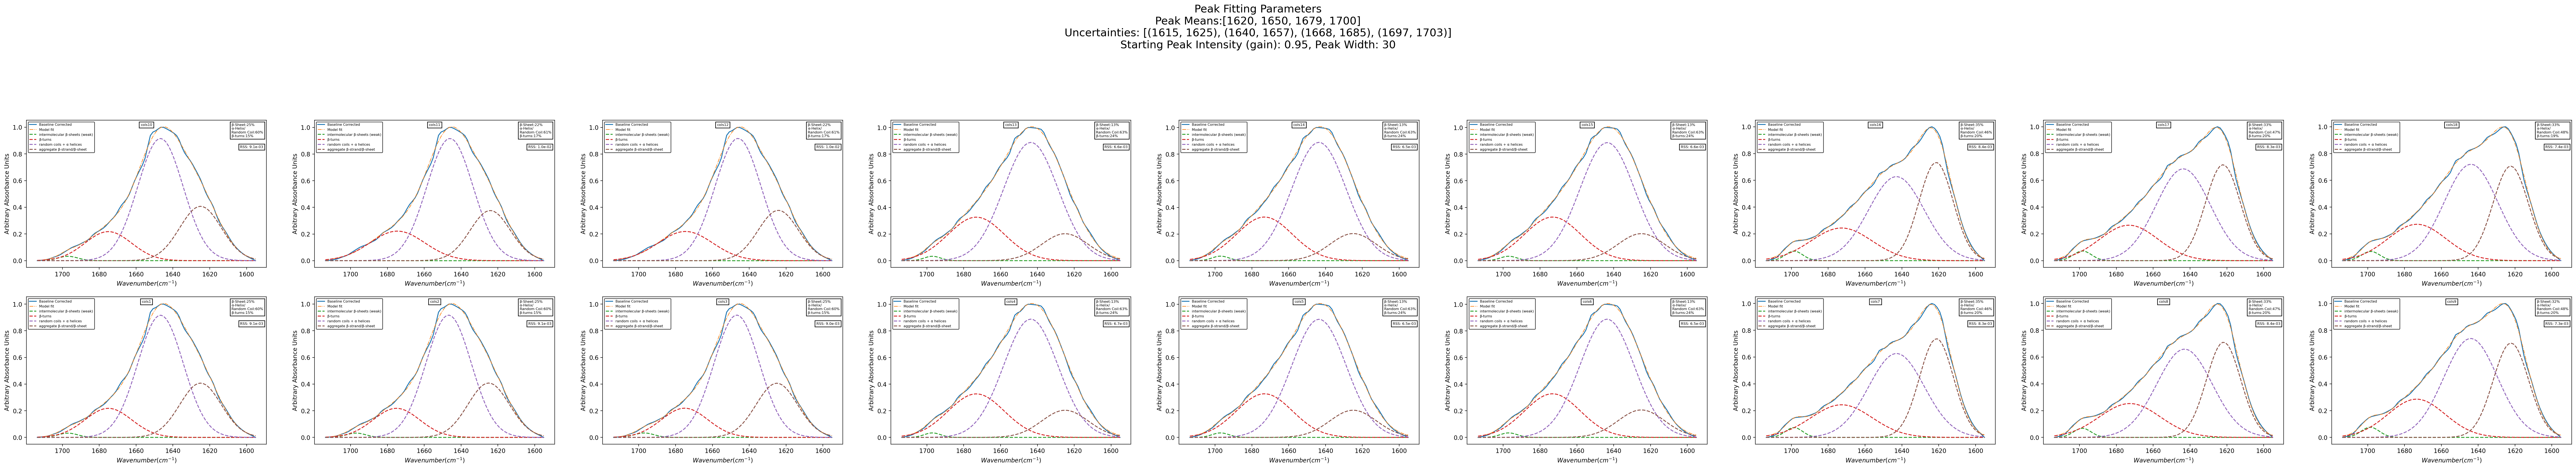

In [18]:
# Jeff 8/25/2022: attempt to redo this portion more simply. Import it as is, and if the file is an image from the microscope (multiple spectra in one file), then flip it
reluncert = 5
gainnum = 0.95 #gain, was originally 0.95

#  Approach: make a grid as it is pulled forom non-flattened indices so that I can more easily think about the math for propper placement of "pixels"; from above, the plots start at top left, but
# should actually start at bottom left. Need to confirm if the grid is started from another corner whether the FT-IR starts measuring from another corner, and then possibly put another gui to allow 
# users to select which corner data collection starts in
pw = 30 #peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
peakfitlibname = 'four_peak'
peaksfittinglib = four_peak 

from matplotlib.offsetbox import AnchoredText


fig, axs = plt.subplots(num_in_y,num_in_x, figsize=(num_in_x*8.5,num_in_y*5),dpi=200)
titletext  = ('Peak Fitting Parameters' + '\n' + 'Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Uncertainties: ' + str(peaksfittinglib['uncertainties']) + 
    "\n" + 'Starting Peak Intensity (gain): ' + str(gainnum) + ', Peak Width: ' + str(pw))
#plt.title('Mean WRFv3.5 LHF', fontsize=40)
fig.suptitle(titletext, fontsize=18,y=1.15, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)


structs =[]
gaussian_data = []
secondary_structs_df = pd.DataFrame()

for j in range(0,num_in_y):
    for i in range(0,num_in_x):     

        indexnum=(num_in_x)*(num_in_y-(j+1))+i #this should convert current index to the correct index from the original "linear" dataset 
        #since the data point table doesn't have any location information
        # need to confirm that if data collection starts in another corner other than lower left (upper right, lower right, etc.), 
        # that this doesn't require a different re-indexing operation
        sample = baseline_corrected_AmideI[indexnum].columns[1]
        area, res = gaussian_least_squares(baseline_corrected_AmideI[indexnum], 
                                        baseline_corrected_AmideI[indexnum].columns[1], peak_width=pw, 
                                        peaks=peaksfittinglib, params={'loss':'linear'}) 
        structs.append(secondary_structure(area, peaksfittinglib)) #secondary_structure() returns dict-> make a dataframe? Jeff 8.25
        gaussian_list_data = gaussian_list(baseline_corrected_AmideI[indexnum]['wavenumber'], *res.x)
        gaussian_data.append(gaussian_list_data)
        secondary_structs_df.append(pd.DataFrame.from_dict(structs, orient='columns'))

        #does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
        xdata = baseline_corrected_AmideI[indexnum].iloc[:,0]
        y_fit = sum(gaussian_list_data)
        #probably should have just done this normally and then transposed/flipped the data frame. Maybe next time 

        # index is a bit whack here, need to start from bottom left and starts from top left 
        #      
        # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
        if (num_in_y == 1) or (num_in_x == 1):
            #need to modify this still to work if it's a y-direction sinle line (just need to change index somehow with j and i maybe?)
            axs[i].plot(xdata, baseline_corrected_AmideI[i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            #add a dataframe to collect max values
            #maxpeaksforeachcurve_df = []
            
            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            
            for k in range(0,len(gaussian_list_data)):
                axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
                #also label the maximum value for each of the 4 peaks? to do later Jeff 8.25.22
                # #would be something like this:
                # a = list(gaussian_list_data[k])
                # print(xdata[a.index(max(a))])
                # #put them in a df below
                # #maxpeaksforeachcurve_df = []
            axs[i].invert_xaxis()
            
            legend1 = axs[i].legend(loc="upper left",fontsize='small',frameon=True)
            legend1.get_frame().set_edgecolor('k')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=8), frameon=True, bbox_to_anchor=(1., 0.8),bbox_transform=axs[i].transAxes)           
            ratioText = ('\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) +'\n' +'\u03B1-Helix/' + '\n' +'Random Coil:'+ str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'] ))+
                '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'] )))
            axs[i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=8), frameon=True)
            axs[i].add_artist(aRatioText)
            #strindexnum= str(indexnum)
            strindexnum= str(baseline_corrected_AmideI[indexnum].columns[1])
            #take out if you want to keep number after .!!!
            strindexnum = strindexnum.split('.')[0]
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')

            numberinlist = AnchoredText(strindexnum, loc='upper center', prop=dict(size=9),frameon=True)
            axs[i].add_artist(numberinlist)        
        else:
            axs[j,i].plot(xdata, baseline_corrected_AmideI[indexnum][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[j,i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[j,i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
            axs[j,i].invert_xaxis()
            
            legend1 = axs[j,i].legend(loc="upper left",fontsize='xx-small',)
            legend1.get_frame().set_edgecolor('k')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.85),bbox_transform=axs[j,i].transAxes)           
            ratioText = ('\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) +'\n' +'\u03B1-Helix/'+'\n' + 'Random Coil:'+ str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'] ))+
                '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'] )))
            axs[j,i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True)
            axs[j,i].add_artist(aRatioText)
            #strindexnum= str(indexnum)
            strindexnum= str(baseline_corrected_AmideI[indexnum].columns[1])
            numberinlist = AnchoredText(strindexnum, loc='upper center', prop=dict(size=6), frameon=True)
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')
            axs[j,i].add_artist(numberinlist)

fullfigname = (savefolderpath+'/'+'spectra.png')
plt.savefig(fullfigname)

In [22]:
list_of_total_beta= []
for i in range(len(structs)):
    list_of_total_beta.append(structs[i]['aggregate \u03B2-strand/\u03B2-sheet']+structs[i]['intermolecular \u03B2-sheets (weak)'])
list_of_total_beta[:]

#condition_list = [9,9,9,0,0,0,0,0,0]
condition_list = ['37C WA','37C WA','37C WA','As Dried','As Dried','As Dried','MeOH Immersion','MeOH Immersion','MeOH Immersion',
'37C WA','37C WA','37C WA','As Dried','As Dried','As Dried','MeOH Immersion','MeOH Immersion','MeOH Immersion']
combinedConditionBetadict = {'Condition':condition_list,'total beta-sheet': list_of_total_beta}
# df_of_total_beta = pd.DataFrame(list_of_UV_exposure,list_of_total_beta, columns = ['UV exposure', 'total beta sheet'])
df_of_total_beta = pd.DataFrame(combinedConditionBetadict)
df_of_total_beta

,Condition,total beta-sheet
0,37C WA,0.253551
1,37C WA,0.216910
2,37C WA,0.218803
3,As Dried,0.129615
4,As Dried,0.130549
5,As Dried,0.130697
6,MeOH Immersion,0.345545
7,MeOH Immersion,0.332929
8,MeOH Immersion,0.325851
9,37C WA,0.252033


In [23]:
df_of_total_beta["Condition"]

0             37C WA
1             37C WA
2             37C WA
3           As Dried
4           As Dried
5           As Dried
6     MeOH Immersion
7     MeOH Immersion
8     MeOH Immersion
9             37C WA
10            37C WA
11            37C WA
12          As Dried
13          As Dried
14          As Dried
15    MeOH Immersion
16    MeOH Immersion
17    MeOH Immersion
Name: Condition, dtype: object

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

As Dried v.s. 37C WA: Welch's t-test independent samples with Bonferroni correction, P_val=6.808e-05 stat=-1.501e+01
37C WA v.s. MeOH Immersion: Welch's t-test independent samples with Bonferroni correction, P_val=1.170e-05 stat=-1.084e+01
As Dried v.s. MeOH Immersion: Welch's t-test independent samples with Bonferroni correction, P_val=2.192e-07 stat=-4.600e+01


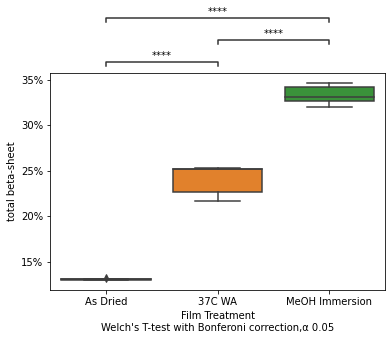

In [26]:
# Make an ANOVA test plot with p-value/significance displayed
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.ticker as mtick
# print(df_of_total_beta['UV Exposure Time'])
# print(df_of_total_beta["total beta-sheet"])

order = ['As Dried','37C WA','MeOH Immersion']
ax = sns.boxplot(data =df_of_total_beta, x =df_of_total_beta['Condition'],
y = df_of_total_beta["total beta-sheet"],order=order)

testresults = add_stat_annotation(ax, x = df_of_total_beta['Condition'],
y = df_of_total_beta["total beta-sheet"],test='t-test_welch', text_format='star', 
loc='outside', verbose=2, box_pairs = [('As Dried','MeOH Immersion'),
('As Dried','37C WA'),('37C WA','MeOH Immersion')], 
order = order)

StatsText = AnchoredText('test',loc='upper right', prop=dict(size=6), frameon=True)
# ax.add_artist(StatsText)
# Titletext  = ('p-value')
# #plt.title('Mean WRFv3.5 LHF', fontsize=40)
# fig.suptitle(titletext, fontsize=18,y=1.15, va='top')

ax.set_xlabel('Film Treatment' +'\n'+"Welch's T-test with Bonferoni correction,\u03B1 0.05")
#ax.ylabel('%', fontweight ='bold', fontsize = 15)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.show()

In [34]:
structs[1]
       
df = pd.DataFrame(structs) 
    
df.to_csv('Test.csv') 

4


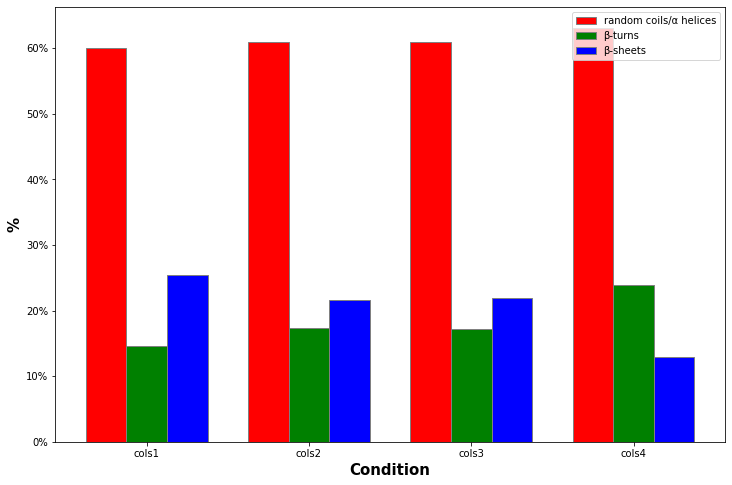

In [27]:
#Some bar plots for Taehoon and in general!
BS = [] 
RCAH = []
BT = []
labels = []

import matplotlib.ticker as mtick

#Plot the Values, bar plot (do each on top of each other for 3 types)
barWidth = 0.25
fig,axs = plt.subplots(figsize =(12, 8))

# set height of bar
print(len(structs[:][1]))
for i in range(0,len(structs[:][1])):
        RCAH.append(structs[:][i]['random coils + \u03B1 helices']) 
        BT.append(structs[:][i]['\u03B2-turns'])
        BS.append(structs[:][i]['aggregate \u03B2-strand/\u03B2-sheet']  +  
        structs[:][i]['intermolecular \u03B2-sheets (weak)'])
        labels.append(baseline_corrected_AmideI[i].columns[1])
        
# Set position of bar on X axis
br1 = np.arange(len(RCAH))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, RCAH, color ='r', width = barWidth,
        edgecolor ='grey', label ='random coils/\u03B1 helices')
plt.bar(br2, BT, color ='g', width = barWidth,
        edgecolor ='grey', label ='\u03B2-turns')
plt.bar(br3, BS, color ='b', width = barWidth,
        edgecolor ='grey', label ='\u03B2-sheets')
 
# Adding Xticks
plt.xlabel('Condition', fontweight ='bold', fontsize = 15)
plt.ylabel('%', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(RCAH))],
        labels)
 
axs.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.legend()
fullfigname2 = (savefolderpath+'/'+'BarPlot.png')
plt.savefig(fullfigname2)
plt.show()

In [23]:
# for j in range(0,len(gaussian_list_data)):    
#     for i in range(0,len(gaussian_data)):
#         a = list(gaussian_data[i][1])
#         #print(a.index(max(a)))
#         print(xdata[a.index(max(a))])
#     print(j)
# #gaussian_list_data[5]

#gaussian_data[0]
structs[41]
#gaussian_list_data

{'intermolecular β-sheets (weak)': 0.006837008535120033,
 'random coils + α helices': 0.534248255563515,
 'aggregate β-strand/β-sheet': 0.29294222691300514,
 'β-turns': 0.16597250898835983}

### FOR NORMALIZED LIST

In [38]:
# # FOR NORMALIZED LIST

# #  Approach: make a grid as it is pulled forom non-flattened indices so that I can more easily think about the math for propper placement of "pixels"; from above, the plots start at top left, but
# # should actually start at bottom left. Need to confirm if the grid is started from another corner whether the FT-IR starts measuring from another corner, and then possibly put another gui to allow 
# # users to select which corner data collection starts in
# pw = 30 #peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
# peakfitlibname = 'four_peak'
# peaksfittinglib = four_peak 

# from matplotlib.offsetbox import AnchoredText

# fig, axs = plt.subplots(num_in_y,num_in_x, figsize=(num_in_x*6,num_in_y*5),dpi=200)
# titletext  = ('Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Peak Relatively Uncertainties: ' + str(peaksfittinglib['relative_uncertainties']) + 
#     "\n" + 'Gain: ' + str(gainnum) + ' Peak Width: ' + str(pw))
# fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
# fig.subplots_adjust(hspace=.2, wspace=.2)

# structs =[]
# gaussian_data = []

# for j in range(0,num_in_y):
#     for i in range(0,num_in_x):     

#         indexnum=(num_in_x)*(num_in_y-(j+1))+i #this should convert current index to the correct index from the original "linear" dataset 
#         #since the data point table doesn't have any location information
#         # need to confirm that if data collection starts in another corner other than lower left (upper right, lower right, etc.), 
#         # that this doesn't require a different re-indexing operation
#         sample = normalized_baseline_AmideI[indexnum].columns[1]
#         area, res = gaussian_least_squares(normalized_baseline_AmideI[indexnum], 
#                                         normalized_baseline_AmideI[indexnum].columns[1], peak_width=pw, 
#                                         peaks=peaksfittinglib, params={'loss':'linear'}) 
#         structs.append(secondary_structure(area, peaksfittinglib)) #secondary_structure() returns dict
#         gaussian_list_data = gaussian_list(normalized_baseline_AmideI[indexnum]['wavenumber'], *res.x)
#         gaussian_data.append(gaussian_list_data)
        
#         #does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
#         xdata = normalized_baseline_AmideI[indexnum].iloc[:,0]
#         y_fit = sum(gaussian_list_data)
#         #probably should have just done this normally and then transposed/flipped the data frame. Maybe next time 

#         # index is a bit whack here, need to start from bottom left and starts from top left 
#         #      
#         # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
#         if (num_in_y == 1) or (num_in_x == 1):
#             axs[i].plot(xdata, normalized_baseline_AmideI[i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
#             axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
#             # calculate RSS for each spectrum
#             resid = normalized_baseline_AmideI[indexnum][sample] - y_fit
#             # sum of square residuals - want to minimize this, might need to run some algorithm to do this
#             rss = sum(resid*resid)

#             # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
#             for k in range(len(gaussian_list_data)):
#                 axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
#                 label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
#             axs[i].invert_xaxis()
            
#             legend1 = axs[i].legend(loc="upper left",fontsize='xx-small')
#             rssTitle = "RSS: "+ str("{:.1e}".format(rss))
#             rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
#             ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
#                 structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
#             axs[i].add_artist(rssText)
#             aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
#                             bbox_transform=axs[i].transAxes)
#             axs[i].add_artist(aRatioText)
#             #strindexnum= str(indexnum)
#             strindexnum= str(normalized_baseline_AmideI[indexnum].columns[1])
#             numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[i].transAxes)
#             axs[i].add_artist(numberinlist)        
#         else:
#             axs[j,i].plot(xdata, normalized_baseline_AmideI[indexnum][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
#             axs[j,i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
#             # calculate RSS for each spectrum
#             resid = normalized_baseline_AmideI[indexnum][sample] - y_fit
#             # sum of square residuals - want to minimize this, might need to run some algorithm to do this
#             rss = sum(resid*resid)

#             # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
#             for k in range(len(gaussian_list_data)):
#                 axs[j,i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
#                 label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
#             axs[j,i].invert_xaxis()
            
#             legend1 = axs[j,i].legend(loc="upper left",fontsize='xx-small')
#             rssTitle = "RSS: "+ str("{:.1e}".format(rss))
#             rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
#             ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
#                 structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
#             axs[j,i].add_artist(rssText)
#             aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
#                             bbox_transform=axs[j,i].transAxes)
#             axs[j,i].add_artist(aRatioText)
#             #strindexnum= str(indexnum)
#             strindexnum= str(normalized_baseline_AmideI[indexnum].columns[1])
#             numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[j,i].transAxes)
#             axs[j,i].add_artist(numberinlist)

# fullfigname = (savefolderpath+'/'+'spectra.png')
# plt.savefig(fullfigname)
# plt.show()
# from matplotlib.offsetbox import AnchoredText

# fig, axs = plt.subplots(num_in_y,num_in_x, figsize=(num_in_x*6,num_in_y*5),dpi=200)
# titletext  = ('Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Peak Relatively Uncertainties: ' + str(peaksfittinglib['relative_uncertainties']) + 
#     "\n" + 'Gain: ' + str(gainnum) + ' Peak Width: ' + str(pw))
# fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
# fig.subplots_adjust(hspace=.2, wspace=.2)

# structs =[]
# gaussian_data = []

# for j in range(0,num_in_y):
#     for i in range(0,num_in_x):     

#         indexnum=indexnum #this should convert current index to the correct index from the original "linear" dataset 
#         #since the data point table doesn't have any location information
#         # need to confirm that if data collection starts in another corner other than lower left (upper right, lower right, etc.), 
#         # that this doesn't require a different re-indexing operation
#         sample = normalized_baseline_AmideI[(num_in_x)*(num_in_y-1-j)+i].columns[1]
#         area, res = gaussian_least_squares(normalized_baseline_AmideI[indexnum], 
#                                         normalized_baseline_AmideI[indexnum].columns[1], peak_width=pw, 
#                                         peaks=peaksfittinglib, params={'loss':'linear'}) 
#         structs.append(secondary_structure(area, peaksfittinglib)) #secondary_structure() returns dict
#         gaussian_list_data = gaussian_list(normalized_baseline_AmideI[indexnum]['wavenumber'], *res.x)
#         gaussian_data.append(gaussian_list_data)
        
#         #does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
#         xdata = normalized_baseline_AmideI[indexnum].iloc[:,0]
#         y_fit = sum(gaussian_list_data)
#         #probably should have just done this normally and then transposed/flipped the data frame. Maybe next time 

#         # index is a bit whack here, need to start from bottom left and starts from top left 
#         #      
#         # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
#         if (num_in_y == 1) or (num_in_x == 1):
#             axs[i].plot(xdata, normalized_baseline_AmideI[i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
#             axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
#             # calculate RSS for each spectrum
#             resid = normalized_baseline_AmideI[indexnum][sample] - y_fit
#             # sum of square residuals - want to minimize this, might need to run some algorithm to do this
#             rss = sum(resid*resid)

#             # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
#             for k in range(len(gaussian_list_data)):
#                 axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
#                 label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
#             axs[i].invert_xaxis()
            
#             legend1 = axs[i].legend(loc="upper left",fontsize='xx-small')
#             rssTitle = "RSS: "+ str("{:.1e}".format(rss))
#             rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
#             ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
#                 structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
#             axs[i].add_artist(rssText)
#             aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
#                             bbox_transform=axs[i].transAxes)
#             axs[i].add_artist(aRatioText)
#             #strindexnum= str(indexnum)
#             strindexnum= str(normalized_baseline_AmideI[indexnum].columns[1])
#             numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[i].transAxes)
#             axs[i].add_artist(numberinlist)        
#         else:
#             axs[j,i].plot(xdata, normalized_baseline_AmideI[indexnum][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
#             axs[j,i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
#             # calculate RSS for each spectrum
#             resid = normalized_baseline_AmideI[indexnum][sample] - y_fit
#             # sum of square residuals - want to minimize this, might need to run some algorithm to do this
#             rss = sum(resid*resid)

#             # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
#             for k in range(len(gaussian_list_data)):
#                 axs[j,i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
#                 label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
#             axs[j,i].invert_xaxis()
            
#             legend1 = axs[j,i].legend(loc="upper left",fontsize='xx-small')
#             rssTitle = "RSS: "+ str("{:.1e}".format(rss))
#             rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
#             ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
#                 structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
#             axs[j,i].add_artist(rssText)
#             aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
#                             bbox_transform=axs[j,i].transAxes)
#             axs[j,i].add_artist(aRatioText)
#             #strindexnum= str(indexnum)
#             strindexnum= str(normalized_baseline_AmideI[indexnum].columns[1])
#             numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[j,i].transAxes)
#             axs[j,i].add_artist(numberinlist)

# # fullfigname = (savefolderpath+'/'+'spectra.png')
# # plt.savefig(fullfigname)
# # plt.show()

In [40]:
#secondary_structs_df[0]

In [43]:
#rawData_df.columns[1:]

In [18]:
#secondary_structs_df

""


Compare % of beta sheet via Seaborn Heatmap

In [30]:
total_beta_percent = []
for i in range(0, len(structs)):
    total_beta_percent.append(
        structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] + structs[i]['intermolecular \u03B2-sheets (weak)'])
#print('type of total_beta_percent:',type(total_beta_percent))
# also make a new dataframe for math later
#total_beta_percent_df = pd.DataFrame(columns = total_beta_percent)

#print('total beta %', total_beta_percent)

# make two DFs, one with all secondary structure values, and then another one with total beta sheet only

secondary_structs_df = pd.DataFrame.from_dict(
    structs, orient='columns')  # columns=rawData_df[2:].columns)
secondary_structs_df = secondary_structs_df.transpose()
secondary_structs_df.columns = rawData_df.columns[1:]
# print(secondary_structs_df)

# for j in range(0,len(structs)):
#     structs_df[j] = pd.DataFrame(list(structs[j].items()), columns=['Structure','Fraction'])
# #structs_df.to_csv('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.csv', index=False)
# print(structs_df)

total_beta_sheet_df = pd.DataFrame(total_beta_percent, columns = ['TotalBetaSheet%'])
total_beta_sheet_df.index = rawData_df.columns[1:]
#rawData_df.columns[0] = rawData_df.columns['fileheader','total beta_sheet %']

extractedtime = []
extractedsamplenumber = []
for i in range(len(rawData_df.columns[1:])):
    splitname = rawData_df.columns[1:][i].split("min")
    extractedtime.append(int(splitname[0]))
    splitname2 = rawData_df.columns[1:][i].split(".")
    extractedsamplenumber.append(splitname2[1])
print(extractedtime)

total_beta_sheet_df['Minutes'] = extractedtime
total_beta_sheet_df['SampleNumber'] = extractedsamplenumber
total_beta_sheet_df = total_beta_sheet_df[['Minutes','SampleNumber','TotalBetaSheet%']]
#print(total_beta_sheet_df)
# #print(total_beta_sheet_df['1hr.0'])
# #print(total_beta_sheet_df['1hr.0']+total_beta_sheet_df['1hr.1'])

# #total_beta_sheet_df[total_beta_sheet_df['Minutes']==5]['TotalBetaSheet%']
# total_beta_sheet_df['TotalBetaSheet%'].plot()
total_beta_percent_60C_df = total_beta_sheet_df
secondary_structs_60C_df = secondary_structs_df


ValueError: invalid literal for int() with base 10: '-0.09359'

In [20]:
total_beta_sheet_df.to_csv("Total_beta_sheet_60.csv", index = False)

In [82]:
# #looking into beta sheet content
# #secondary_structs_df[('5min.0')]

# secondary_structs_df.filter(like='10min')

In [81]:
# import matplotlib.ticker as mtick
# ax = total_beta_sheet_df.iloc[0:17].plot(x='Minutes',y='TotalBetaSheet%',kind = 'scatter',title = '\u03B2-sheet content vs time in 60C Humidity Chamber')
# plt.xscale('log')
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.set_xticklabels([0.1,0,10,100])
# ax.set_ylim(ymin=0)
# ax.set_ylim(ymax=.5)

In [31]:
#Split up points into x by y grid
break_total_beta_percent = np.array_split(np.array(total_beta_percent),num_in_y)
#print(break_total_beta_percent)

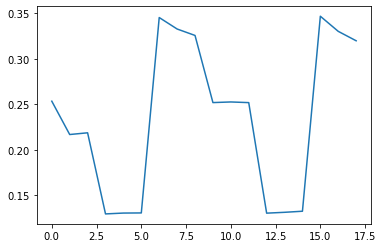

In [32]:
# 2D plot just in case it's useful
plt.plot(total_beta_percent)
fullfigname = (savefolderpath+'/'+'1-D.png')
plt.savefig(fullfigname)


In [33]:
#Chop the dataset up into samples that have beta sheet <35 (WA) and above (MeOH)
MeOHorWA_List = []

for i in range(len(total_beta_percent)):
    if total_beta_percent[i]>0.35:
        MeOHorWA_List.append('MeOH') 
    else:
        MeOHorWA_List.append('WA') #'45C 90% RH 30 minute WA'  

MeOHorWA_List[25:35]

MeOHorWA_DF = pd.DataFrame({'MeOH or WA':MeOHorWA_List,'total beta-sheet percent': total_beta_percent})
# MeOHorWA_DF['MeOH or WA'].append(total_beta_percent[i])
#         MeOHorWA_DF['MeOH or WA'].append(total_beta_percent[i]) 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WA v.s. MeOH: Welch's t-test independent samples, P_val=1.073e-38 stat=-5.625e+01


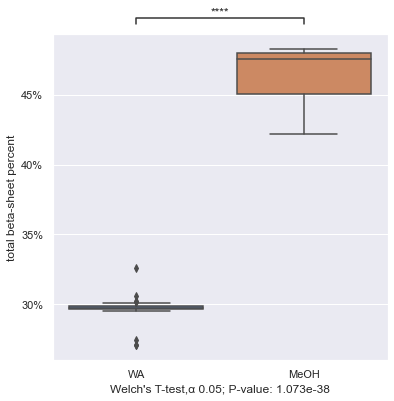

In [80]:
# Make a t-test plot with p-value/significance displayed
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.ticker as mtick
# print(df_of_total_beta['UV Exposure Time'])
# print(df_of_total_beta["total beta-sheet"])

order = ['WA','MeOH']
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.boxplot(data =MeOHorWA_DF, x =MeOHorWA_DF['MeOH or WA'],y = MeOHorWA_DF["total beta-sheet percent"],
order=order)
testresults = add_stat_annotation(ax, x =MeOHorWA_DF['MeOH or WA'],y = MeOHorWA_DF["total beta-sheet percent"],
            test='t-test_welch', text_format='star', loc='outside', verbose=2, box_pairs = [('WA','MeOH')], order = order, comparisons_correction=None)

#StatsText = AnchoredText('test',loc='upper right', prop=dict(size=6), frameon=True)
# ax.add_artist(StatsText)
# Titletext  = ('p-value')
# #plt.title('Mean WRFv3.5 LHF', fontsize=40)
# fig.suptitle(titletext, fontsize=18,y=1.15, va='top')

ax.set_xlabel("Welch's T-test,\u03B1 0.05; P-value: 1.073e-38", size = 12)
#ax.ylabel('%', fontweight ='bold', fontsize = 15)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.show()

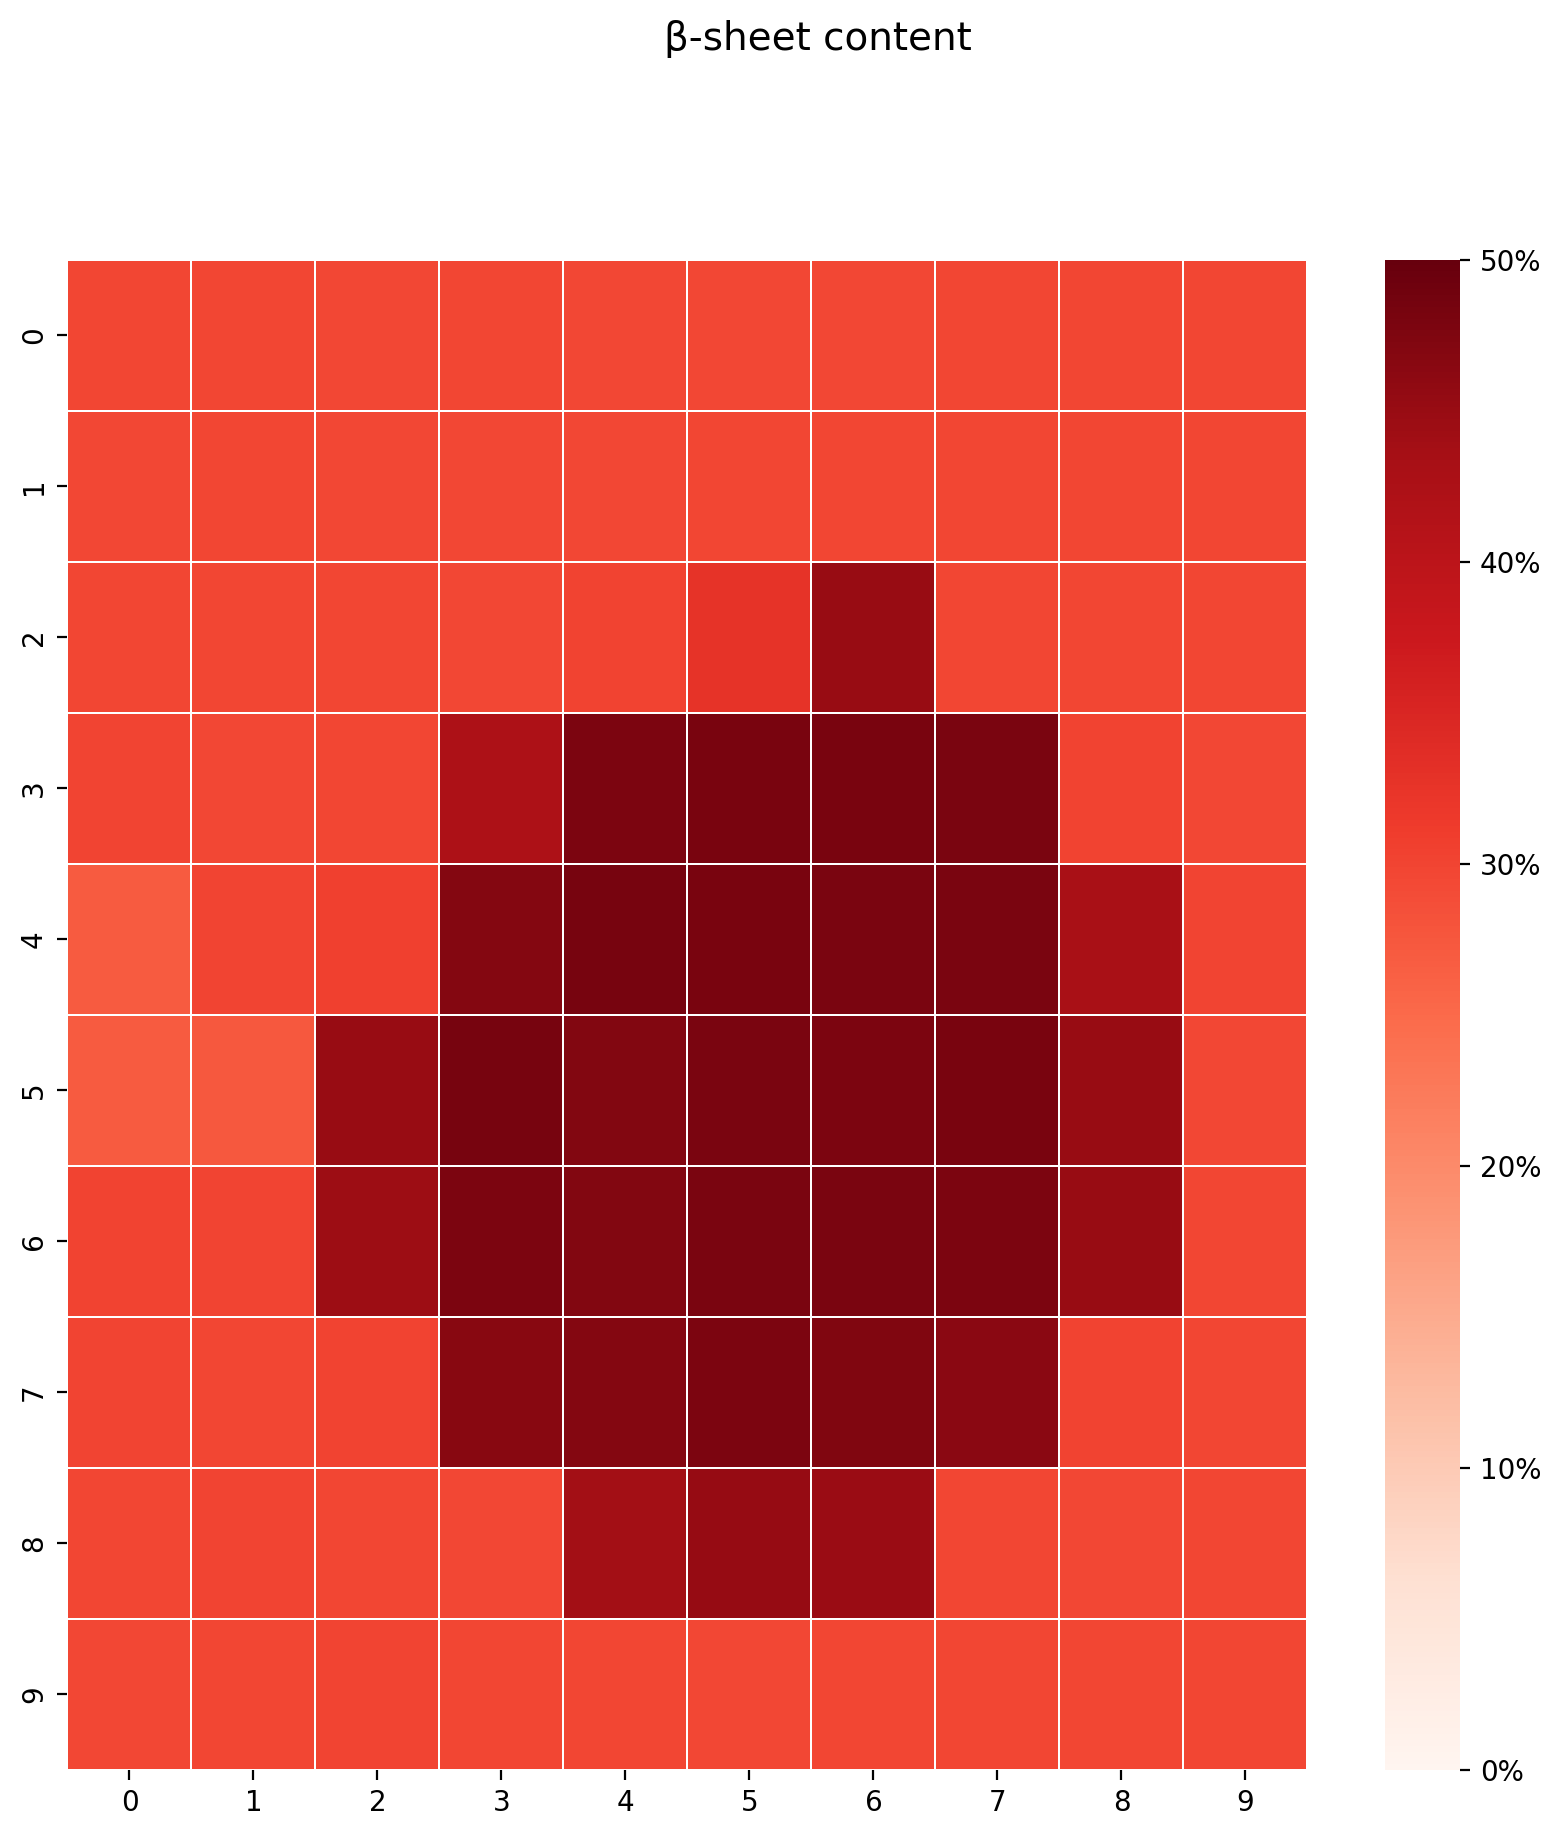

In [47]:
#heatmap via seaborn, plotted from 0 to 50% beta sheet content:
plt.figure(figsize = (num_in_x,num_in_y),dpi=200)

#save beta sheet content into csv; if from single microscopy file, use the shape of the data as it is; if it's from multiple files, save it with the header
fullcsvname = (savefolderpath+'/'+'peakdata.csv')
np.savetxt(fullcsvname, break_total_beta_percent, fmt='%.4f',delimiter=',')

hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=0, vmax=0.5, linewidths=.05)
plt.suptitle(hmtitletext , fontsize=14,y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0,0.1,0.2,0.3,.4,.5])
cbar.set_ticklabels(['0%','10%', '20%', '30%', '40%','50%'])

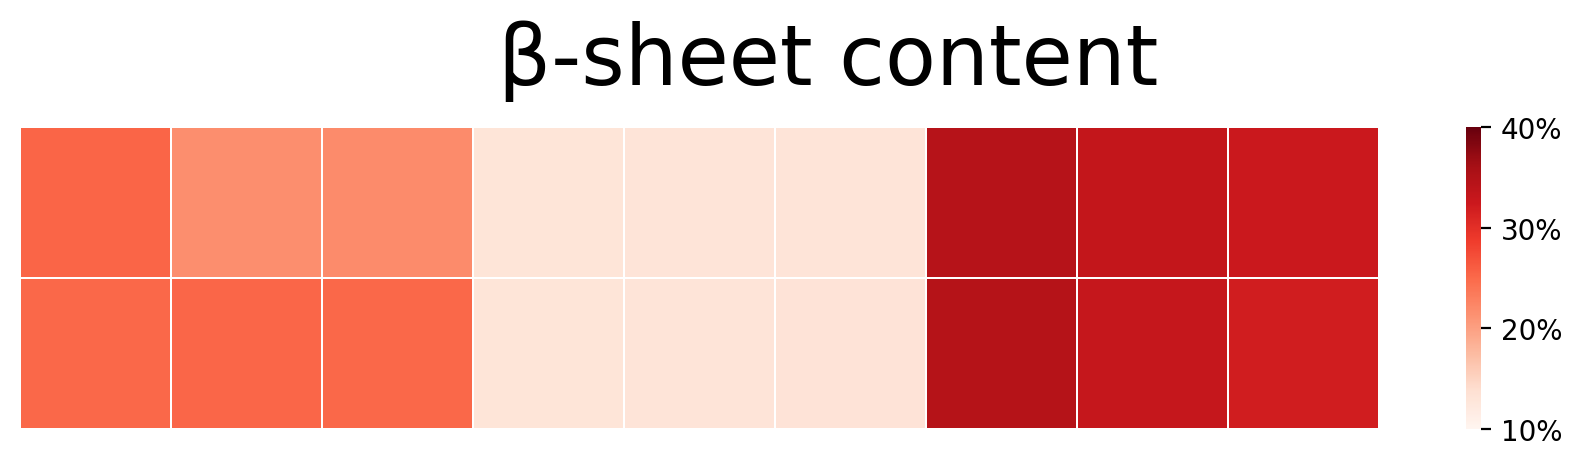

In [36]:
#heatmap via seaborn with automatically changing intensity axis
import math
plt.figure(figsize = (num_in_x*1.25,num_in_y),dpi=200)

#generate mininum and maximum values for colorscale by rounding to the nearest "10", then going down for min and up for max
vminimum = math.floor(min(total_beta_percent)*10)/10
vmaximum = math.ceil(max(total_beta_percent)*10)/10
hmtitletext  = ('\u03B2-sheet content')# + "\n")
ax = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=vminimum, vmax=vmaximum, 
linewidths=.05,square = True,cbar_kws={"shrink":1})
plt.suptitle(hmtitletext , fontsize=30,y=1.15, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
#fig.colorbar(ax=ax)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
# ax.invert_yaxis()
cbar = ax.collections[0].colorbar
l = np.arange(vminimum,vmaximum+.1,0.1)
#print('l', l)
l1 = ["%.1f" % member for member in l*100]
#print('l1', l1)
cbar.set_ticks(l)
l2 =  ["%.0f" % member for member in l*100]
l3 =list(map("{}%".format,l2))
cbar.set_ticklabels(l3)
ax.tick_params(left=False, bottom=False)
ax.set(xlabel=None) 
ax.set(ylabel=None)

#save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapFitScalebar.png')
plt.savefig(fullfigname)

In [ ]:
# #User input heatmap, COMMENT out FOR NOW
# #heatmap via seaborn, beta sheet plotted between user generated endpoints:

# # Input for min and max beta sheet for heatmap scale
# # Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# # Returns bsMin and bsMax globally
# root=tk.Tk()
 
# # setting the windows size
# root.geometry("450x100")
# root.eval('tk::PlaceWindow . center')
# #root.lift()

# # declaring numerical variables for storing x and y values
# bsMin=tk.IntVar()
# bsMax=tk.IntVar()
# bsStep=tk.IntVar()

# # defining a function that will get x and y values and close the window
# def submit():
#     global user_message_entry, bsMinNum,bsMaxNum, bsStepNum
#     # t = Toplevel(root)
#     bsMinNum=int(bsMin.get())
#     bsMaxNum=int(bsMax.get())
#     bsStepNum=int(bsStep.get())
#     print("Total number of spectra: " + str(bsMinNum*bsMaxNum))
#     time.sleep(0.5)
#     root.destroy()
    
# # creating a label for input of min % using widget Label
# bsMin_label = tk.Label(root, text = 'Minimum % for beta-sheet: ', font=('calibre',10, 'bold'))
  
# # creating a entry for input of min % using widget Entry
# bsMin_entry = tk.Entry(root,textvariable = bsMin, font=('calibre',10,'normal'))
  
# # creating a label for input of max % using widget Label
# bsMax_label = tk.Label(root, text = 'Maximum % for beta-sheet: ', font = ('calibre',10,'bold'))
  
# # creating a entry for input of max % using widget Entry
# bsMax_entry=tk.Entry(root, textvariable = bsMax, font = ('calibre',10,'normal'))
  
# # creating a label for input of max % using widget Label
# bsStep_label = tk.Label(root, text = 'Step size in % of beta-sheet for scale bar: ', font = ('calibre',10,'bold'))
  
# # creating a entry for input of max % using widget Entry
# bsStep_entry=tk.Entry(root, textvariable = bsStep, font = ('calibre',10,'normal'))

# # creating a label so user knows input of % should be % using widget Label
# bsStepPercent_label = tk.Label(root, text = '%', font = ('calibre',10,'bold'))

# # creating a button using the widget button that will call the submit function
# sub_btn=tk.Button(root,text = 'Submit', command=lambda: submit())
  
# # placing the label and entry in the required position using grid method
# bsMin_label.grid(row=0,column=0)
# bsMin_entry.grid(row=0,column=1)
# bsMax_label.grid(row=1,column=0)
# bsMax_entry.grid(row=1,column=1)
# bsStep_label.grid(row=2,column=0)
# bsStep_entry.grid(row=2,column=1)
# bsStepPercent_label.grid(row=2,column=2)
# sub_btn.grid(row=3,column=1)

# # performing an infinite loop for the window to display
# root.mainloop()

# plt.figure(figsize = (num_in_x,num_in_y),dpi=200)

# hmtitletext  = ('\u03B2-sheet content' + "\n")
# ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=bsMinNum/100, vmax=bsMaxNum/100, linewidths=.05)
# plt.suptitle(hmtitletext , fontsize=16,y=1.1, va='top')
# fig.subplots_adjust(hspace=.2, wspace=.2)
# # ax_example.invert_yaxis()
# cbar = ax_example.collections[0].colorbar

# l = np.arange(bsMinNum/100,bsMaxNum/100+.1,bsStepNum/100)
# cbar.set_ticks(l)
# print('l', l)
# l1 = ["%.1f" % member for member in l*100]
# print('l1', l1)

# l2 =  ["%.0f" % member for member in l*100]
# l3 =list(map("{}%".format,l2))
# print('l3', l3)
# cbar.set_ticklabels(l3)

# #save heatmap into file
# fullfigname = (savefolderpath+'/'+'HeatmapUserInputScalebar.png')
# plt.savefig(fullfigname)

#Statistics

In [ ]:
#crreate Mean, 
total_beta_sheet_df['5min.0']


In [ ]:
#plot beta sheet concentration vs time
fig, ax = plt.subplots(figsize=(20, 10),constrained_layout=True) 

titletext  = ('\u03B2-sheet content vs Water Annealing Temperature and Time')
fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
ax.plot(total_beta_sheet_df.columns,total_beta_percent,label='60C')

plt.show()